In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!nvidia-smi

Tue Dec 10 19:21:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
PATH = 'gdrive/My Drive/quora-question-pairs/'

Q1_TRAIN = 'q1_train.npy'
Q2_TRAIN = 'q2_train.npy'
LABEL_TRAIN = 'label_train.npy'
WORD_EMBEDDING_MATRIX = 'word_embedding_matrix.npy'
NB_WORDS = 'word_index_cleanup.json'
MODEL_WEIGHTS = 'question_pairs_weights.h5'
MAX_SEQ_LENGTH = 50
EMBEDDING_DIM = 300

EPOCHS = 25
DROPOUT = 0
BATCH_SIZE = 32

In [0]:
# Loading dataset
q1_data = np.load(open(PATH + Q1_TRAIN, 'rb'))
q2_data = np.load(open(PATH + Q2_TRAIN, 'rb'))
labels = np.load(open(PATH + LABEL_TRAIN, 'rb'))
word_embedding_matrix = np.load(open(PATH + WORD_EMBEDDING_MATRIX, 'rb'))
with open(PATH + NB_WORDS, 'r') as f:
    nb_words = json.load(f)['nb_words']

In [0]:
# Split dataset to get validation and test sets.
X = np.stack((q1_data, q2_data), axis=1)
y = labels

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test =  train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_val = X_val[:,0]
Q2_val = X_val[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

In [0]:
question1 = Input(shape=(MAX_SEQ_LENGTH,))
question2 = Input(shape=(MAX_SEQ_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQ_LENGTH, 
                 trainable=False)(question1)
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQ_LENGTH, 
                 trainable=False)(question2)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

merged = concatenate([q1,q2])
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      24293400    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      24293400    input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(PATH + MODEL_WEIGHTS, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train], y_train,
                    epochs=EPOCHS, validation_data=([Q1_val, Q2_val], y_val),
                    verbose=2, batch_size=BATCH_SIZE, callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-12-10 19:22:57.575394


Train on 323432 samples, validate on 40429 samples
Epoch 1/25
 - 121s - loss: 0.4973 - acc: 0.7501 - val_loss: 0.4509 - val_acc: 0.7746
Epoch 2/25
 - 120s - loss: 0.4411 - acc: 0.7854 - val_loss: 0.4419 - val_acc: 0.7877
Epoch 3/25
 - 120s - loss: 0.4097 - acc: 0.8045 - val_loss: 0.4159 - val_acc: 0.7995
Epoch 4/25
 - 120s - loss: 0.3863 - acc: 0.8184 - val_loss: 0.4110 - val_acc: 0.8026
Epoch 5/25
 - 120s - loss: 0.3665 - acc: 0.8314 - val_loss: 0.3954 - val_acc: 0.8142
Epoch 6/25
 - 120s - loss: 0.3477 - acc: 0.8415 - val_loss: 0.3973 - val_acc: 0.8129
Epoch 7/25
 - 118s - loss: 0.3322 - acc: 0.8508 - val_loss: 0.4050 - val_acc: 0.8103
Epoch 8/25
 - 119s - loss: 0.3180 - acc: 0.8581 - val_loss: 0.3958 - val_acc: 0.8166
Epoch 9/25
 - 118s - loss: 0.3046 - acc: 0.8661 - val_loss: 0.4129 - val_acc: 0.8141
Epoch 10/25
 - 119s - loss: 0.2928 - acc: 0.8714 - val_loss: 0.4158 - val_acc: 0.8102
Epoch 11/25
 - 120s - loss: 0.2825 - acc: 0.8770

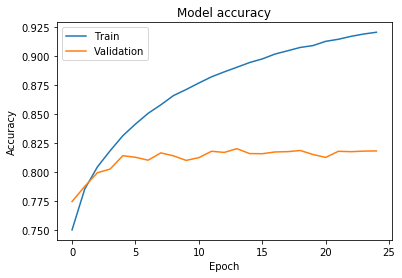

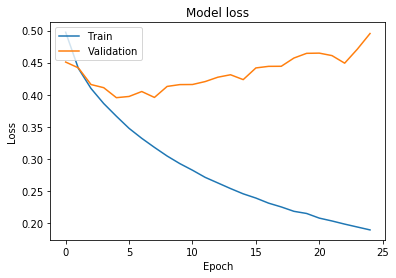

In [0]:

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Best accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Best accuracy at epoch 14 = 0.8203


In [0]:
model.load_weights(PATH + MODEL_WEIGHTS)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('Test set accuracy = {1:.4f}'.format(loss, accuracy))

Test set accuracy = 0.8154
